# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

### 1. Import Packages

In [128]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)

<module 'util.load_Data' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Machine Learning in Network Science\\3_challenge\\Network-Science_Challenge\\util\\load_Data.py'>

In [1]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData

In [2]:
# parse & handle data
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data

# generate decision rules
from apyori import apriori

# clustering
import hdbscan

# dimensionaliy reduction
import umap
import umap.plot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# evaluation
from sklearn.metrics import ConfusionMatrixDisplay

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data

In [4]:
# read node information
node_info = (pd.read_csv('data/node_information.csv', index_col = 0, header = None)
                 .rename_axis("node"))
node_info.shape

(3597, 932)

In [5]:
# read edge lists (train and test)
train = pd.read_csv('data/train.txt', header = None, sep = " ").rename(columns = {0: "node1", 1: "node2", 2: "y"})
test  = pd.read_csv('data/test.txt' , header = None, sep = " ").rename(columns = {0: "node1", 1: "node2"})

# sort edge lists (so lower numbered node is always in first column)
train = train[["node1", "node2"]].apply(lambda x: np.sort(x), axis = 1, raw = True).assign(y = train.y)
test  = test[[ "node1", "node2"]].apply(lambda x: np.sort(x), axis = 1, raw = True)

### 3. Missing values, duplicates and find possible data leakage

#### 3.1 Edge lists

There are no duplicates in the dataset! Also no edges that are present in both train and test!

In [6]:
# number of duplicates in train
print(train.shape)
train.duplicated(subset = ["node1", "node2"]).value_counts()

(10496, 3)


False    10496
dtype: int64

In [7]:
# number of duplicates in test
print(test.shape)
test.duplicated().value_counts()

(3498, 2)


False    3498
dtype: int64

In [8]:
# number of edges present in both datasets
all_data = pd.concat([train[["node1", "node2"]], test])
print(all_data.shape)
all_data.duplicated().value_counts()

(13994, 2)


False    13994
dtype: int64

Are there any predictions where both nodes are the same? (if so, prediction should always be 1)

In [9]:
# how many edges have the same source and target node?
print(train.loc[train["node1"] == train["node2"]].shape)
print(test.loc[test["node1"] == test["node2"]].shape)

# remove those edges from the data (we will just predict 1 for them)
train = prepData.clean_edgelist(train)
test  = prepData.clean_edgelist(test)

(31, 3)
(17, 2)


create our graph based on the training data
- without edges where source and target are the same (doesn't make sense)
- without not actual edges (where y is 0)

In [10]:
# create graph
G = prepData.fetch_graph(train)

# validate (same number of edges?)
print(train.loc[((train.node1 != train.node2) & (train.y == 1))].shape)
print(G.number_of_edges())

# check if graph is connected -- if not, return greatest connected component subgraph
gcc = prepData.get_gcc(G)

(5217, 3)
5217
The graph is connected


#### 3.2 Node Information

In [11]:
# missing values
node_info.isnull().sum().sum()

0

In [12]:
# completely empty columns
empty_cols = node_info.columns[node_info.nunique() == 1].values
print(empty_cols)

# remove them from the dataframea
node_info = node_info.drop(columns = empty_cols, inplace = False)

[657 784 895]


In [13]:
# get dict of unique embeddings in our data
emb_dict = {}
emb_id = 0
for i in node_info.index:
    emb = tuple(node_info.loc[i].values)
    if emb not in emb_dict:
        emb_dict[emb] = emb_id
        emb_id += 1
print(f"Number of unique embeddings: {len(emb_dict)}")

Number of unique embeddings: 2972


In [14]:
# number of duplicates
print(node_info.shape)
node_info_tf = (node_info
    .assign(emb_id    = lambda df_: [emb_dict[tuple(df_.loc[i].values)] for i in df_.index])
    .assign(duplicate = lambda df_: df_.duplicated(keep = False))
)
node_info_tf.duplicate.value_counts()

(3597, 929)


False    2786
True      811
Name: duplicate, dtype: int64

In [15]:
# show duplicated data grouped by unique embedding id
node_info_tf.loc[node_info_tf.duplicate == True].groupby("emb_id", group_keys = True).apply(lambda x: x)

1    2    3    4    5    6    7    8    9   10  ...  925  926  \
emb_id node                                                    ...             
2      5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       1747  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3      6     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       673   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       1842  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2517   6521  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2523   6156  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       6327  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2770   6923  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       7260  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

             927  928  929  930  931  932  emb_id  duplicate  
emb_id node                                                   
2      5     0.0  0.0  0.0  0.0  0.0  0.0       2       True  
       1747  0.0  0.0  0.0  0.0  0.0  0.0       2       True  
3      6     0.0  0.0  0.0  0.0  0.0  0.0       3       True  
       673   0.0  0.0  0.0  0.0  0.0  0.0       3       True  
       1842  0.0  0.0  0.0  0.0  0.0  0.0       3       True  
...          ...  ...  ...  ...  ...  ...     ...        ...  
2517   6521  0.0  0.0  0.0  0.0  0.0  0.0    2517       True  
2523   6156  0.0  0.0  0.0  0.0  0.0  0.0    2523       True  
       6327  0.0  0.0  0.0  0.0  0.0  0.0    2523       True  
2770   6923  0.0  0.0  0.0  0.0  0.0  0.0    2770       True  
       7260  0.0  0.0  0.0  0.0  0.0  0.0    2770       True  

[811 rows x 931 columns]

In [16]:
# number of unique embeddings in the duplicated data
node_info_tf.loc[node_info_tf.duplicate == True].emb_id.nunique()

186

In [17]:
# number of unique embeddings in the duplicated data
node_info_tf.loc[node_info_tf.duplicate == True].emb_id.value_counts().head(10)

67     82
25     37
94     35
88     28
73     21
148    19
97     19
199    18
16     16
6      13
Name: emb_id, dtype: int64

811 node embeddings are pure duplicates (only 186 unique embeddings among the 811 vectors). But do they also have the same set of neighbours?

In [18]:
# get neighbors of each node
node_info_tf = (node_info_tf
    .assign(neighbors = lambda df_: [tuple(set([i for i in nx.all_neighbors(G, node)])) for node in df_.index]))

In [19]:
# show duplicated data that also have same neighbors grouped by unique embedding id
node_info_tf.loc[node_info_tf.duplicated(keep = False)].groupby("emb_id", group_keys = True).apply(lambda x: x)

1    2    3    4    5    6    7    8    9   10  ...  926  927  \
emb_id node                                                    ...             
25     733   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       3319  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       3518  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
67     714   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       1344  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       3492  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
88     1953  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       1981  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       2283  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       2388  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
94     1526  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       3693  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
97     266   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       1024  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       2870  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
466    939   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       1715  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
508    1028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       1188  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
903    2015  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       3610  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

             928  929  930  931  932  emb_id  duplicate  neighbors  
emb_id node                                                         
25     733   0.0  0.0  0.0  0.0  0.0      25       True    (3809,)  
       3319  0.0  0.0  0.0  0.0  0.0      25       True    (3809,)  
       3518  0.0  0.0  0.0  0.0  0.0      25       True    (3809,)  
67     714   0.0  0.0  0.0  0.0  1.0      67       True    (3809,)  
       1344  0.0  0.0  0.0  0.0  1.0      67       True    (3809,)  
       3492  0.0  0.0  0.0  0.0  1.0      67       True    (3809,)  
88     1953  0.0  0.0  0.0  0.0  0.0      88       True    (3809,)  
       1981  0.0  0.0  0.0  0.0  0.0      88       True    (3809,)  
       2283  0.0  0.0  0.0  0.0  0.0      88       True    (3809,)  
       2388  0.0  0.0  0.0  0.0  0.0      88       True    (3809,)  
94     1526  0.0  0.0  0.0  0.0  0.0      94       True    (3809,)  
       2010  0.0  0.0  0.0  0.0  0.0      94       True    (3809,)  
       3693  0.0  0.0  0.0  0.0  0.0      94       True    (3809,)  
97     266   0.0  0.0  0.0  0.0  0.0      97       True    (3809,)  
       1024  0.0  0.0  0.0  0.0  0.0      97       True    (3809,)  
       2870  0.0  0.0  0.0  0.0  0.0      97       True    (3809,)  
466    939   0.0  0.0  0.0  0.0  0.0     466       True    (3809,)  
       1715  0.0  0.0  0.0  0.0  0.0     466       True    (3809,)  
508    1028  0.0  0.0  0.0  0.0  0.0     508       True    (3809,)  
       1188  0.0  0.0  0.0  0.0  0.0     508       True    (3809,)  
903    2015  0.0  0.0  0.0  0.0  0.0     903       True    (3809,)  
       3610  0.0  0.0  0.0  0.0  0.0     903       True    (3809,)  

[22 rows x 932 columns]

22 nodes have the same embedding as well as the same set of neighbors!

To better perform dimensionality reduction on the node embeddings, we will only keep the 2,972 unique embeddings and create a mapping between which node relates to which embedding.

In [20]:
node_info_uq = (node_info
    .drop_duplicates(keep = "first")
    .assign(emb_id = lambda df_: [emb_dict[tuple(df_.loc[i].values)] for i in df_.index])
    .set_index("emb_id"))

node_info_map = (node_info
    .assign(emb_id = lambda df_: [emb_dict[tuple(df_.loc[i].values)] for i in df_.index])
)[["emb_id"]]

### 4. Graph Analysis

In [16]:
# get basic stats of network
prop = analyseData.compute_network_characteristics(graph = G)
print("Number of nodes: {}".format(prop['N']))
print("Number of edges: {}".format(prop['M']))
print("Min. degree: {}".format(prop['min_degree']))
print("Max. degree: {}".format(prop['max_degree']))
print("Mean degree: {}".format(prop['mean_degree']))
print("Median degree: {}".format(prop['median_degree']))
print("Density: {}".format(prop['density']))
print("Avg. clustering coefficient: {}".format(prop['avg_clustering']))
print("Avg. shortest path: {}".format(prop['avg_shortest_path']))

Number of nodes: 3597
Number of edges: 5217
Min. degree: 1
Max. degree: 361
Mean degree: 2.9007506255212676
Median degree: 2.0
Density: 0.000806660351924713
Avg. clustering coefficient: 0.019560058406301813
Avg. shortest path: 6.038627233236943


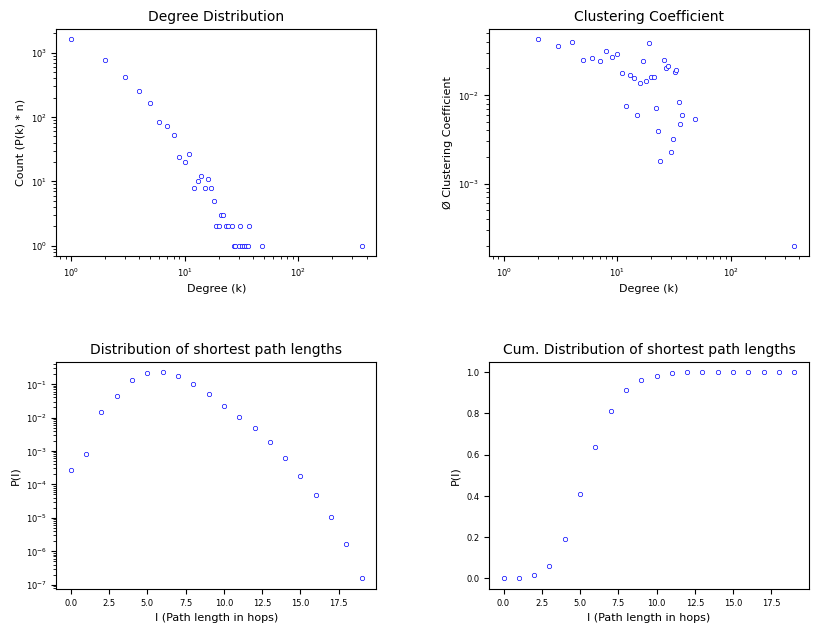

In [17]:
analyseData.plot_graph_stats(G)

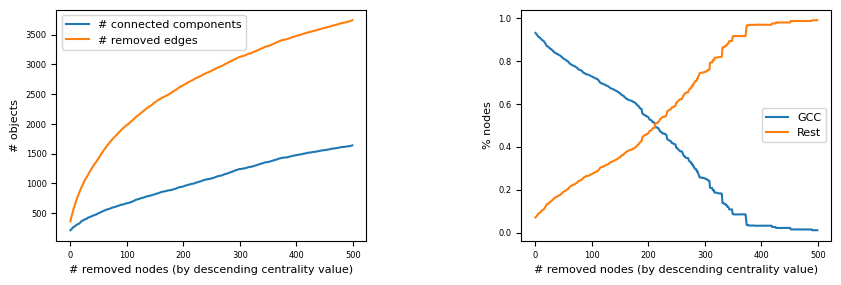

In [18]:
# choose a centrality measure
node2values = nx.degree_centrality(G)
k = 500 # k is the number of nodes to be removed
analyseData.plot_robustness_analysis(G, node2values, k)

### 5. Graph-based features

To understand the usefulness of potential graph-based features, we need to perform a train-validation split, perform the feature extraction and validate the feature importance on the validation set.

In [129]:
# might take up to a minute
(G, G_train, node_info,
 train_tf, val_tf, trainval_tf,
 test, test_tf,
 X_train, y_train, X_val, y_val, X_trainval, y_trainval,
 X_test) = loadData.load_transform(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected
Enriching train data...
Enriching validation data...
Enriching test data...


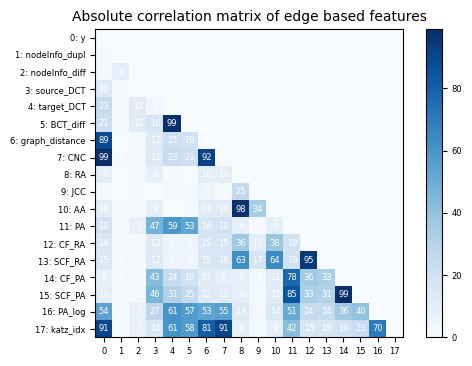

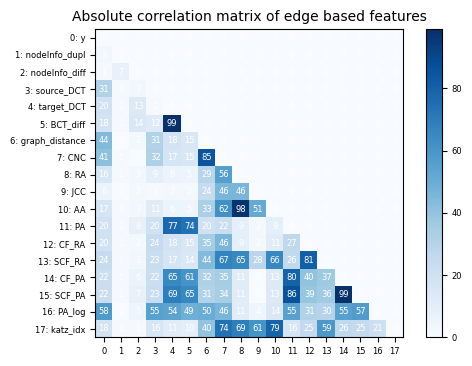

In [130]:
# plot correlation with target (first train, then validation)
for df in [train_tf, val_tf]:
    analyseData.plot_corr_matrix(df.iloc[:, 2:])

In [62]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [86]:
# basic XGBoost (best to use for RFECV as very short runtime)
clf = XGBClassifier(n_estimators = 100, max_depth = 3, eta = 0.05,
                    colsample_bytree = 0.2, colsample_bylevel = 0.5,
                    reg_alpha = 100)
clf.fit(X_train, y_train)

# predict train
y_train_hat = clf.predict(X_train)
# compute R^2 metric
acc_train = accuracy_score(y_train, y_train_hat)

# predict val
y_val_hat = clf.predict(X_val)
# compute R^2 metric
acc_val = accuracy_score(y_val, y_val_hat)

# print performance
print(f"Acc train: {acc_train}")
print(f"Acc val : {acc_val}")

Acc train: 0.8707596751075012
Acc val : 0.774964166268514


In [97]:
# basic XGBoost (best to use for RFECV as very short runtime)
clf = LogisticRegression(max_iter = 500, C = 0.00002)
clf.fit(X_train, y_train)

# predict train
y_train_hat = clf.predict(X_train)
# compute R^2 metric
acc_train = accuracy_score(y_train, y_train_hat)

# predict val
y_val_hat = clf.predict(X_val)
# compute R^2 metric
acc_val = accuracy_score(y_val, y_val_hat)

# print performance
print(f"Acc train: {acc_train}")
print(f"Acc val : {acc_val}")

Acc train: 0.7270664118490205
Acc val : 0.727663640707119


### 6. Node embedding features

#### 6.1 Analysis of node embeddings

Let us first start by looking at the distribution of:
- the number of keywords per node
- the number of nodes per keyword

In [52]:
kws_per_node = (node_info_uq
    .assign(kws = lambda df_: [sorted(set([col + 1 for col, val in enumerate(df_.loc[i]) if val != 0])) for i in df_.index])
    .kws.to_frame()
    .assign(num_kws = lambda df_: [len(kw) for kw in df_.kws])
)

kws_per_node.head(3)

,kws,num_kws
emb_id,,
0,"[22, 24, 28, 29, 79, 92, 292, 522, 571, 704, 776]",11
1,"[56, 92, 93, 112, 139, 298, 522, 660]",8
2,"[93, 139, 571, 616]",4


In [53]:
nodes_per_kw = pd.DataFrame.from_dict(dict(node_info_uq.sum().astype(int)), orient = "index", columns = ["num_nodes"])

nodes_per_kw.head(3)

,num_nodes
1,4
2,3
3,1


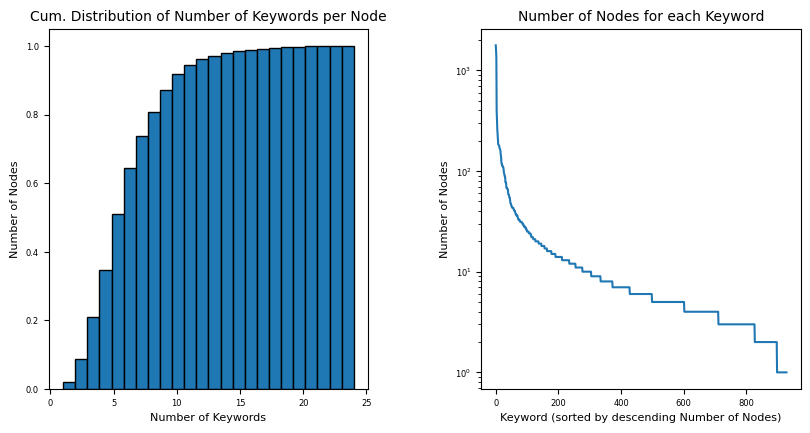

In [54]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.tight_layout(w_pad = 10)

kws_per_node.num_kws.hist(ax = ax[0], bins = max(kws_per_node.num_kws), edgecolor="black", grid = False,
                          cumulative = True, density = 1)
ax[0].set_xlabel("Number of Keywords")
ax[0].set_ylabel("Number of Nodes")
ax[0].set_title("Cum. Distribution of Number of Keywords per Node")

nodes_per_kw.num_nodes.sort_values(ascending = False).plot(ax = ax[1], kind = "line", use_index = False)
ax[1].set_xlabel("Keyword (sorted by descending Number of Nodes)")
ax[1].set_ylabel("Number of Nodes")
ax[1].set_title("Number of Nodes for each Keyword")
ax[1].set_yscale("log")

Takeaways:
- 90% of nodes have less than 10 keywords
- 70% of keywords have less than 10 nodes

In consequence, some keywords are extremely common (and thus probably not very useful for separating keywords) while others are much are much more discriminative. In consequence, it might be a very good idea to transform this matrix using TF-IDF (but as we have only binary representation of keywords, it effectively becomes IDF as term frequency is either 1 or 0). Inverse Document Frequency means that rare keywords weigh more than frequent ones (which is exactly what we want).

DO WE WANT TO RUN IDF ON ORIGINAL NODE EMBEDDINGS (DUPLICATES!!) OR UNIQUE EMBEDDINGS?

In [61]:
node_info_uq_idf = node_info_uq.copy(deep = True)

for col in node_info_uq_idf.columns:
    node_info_uq_idf[col].loc[node_info_uq_idf[col] == 1] = np.log(len(node_info_uq_idf)/(1 + node_info_uq_idf[col].sum()))

In [62]:
nodes_per_kw["idf"] = node_info_uq_idf.max()

Text(0.5, 1.0, 'IDF for each Keyword')

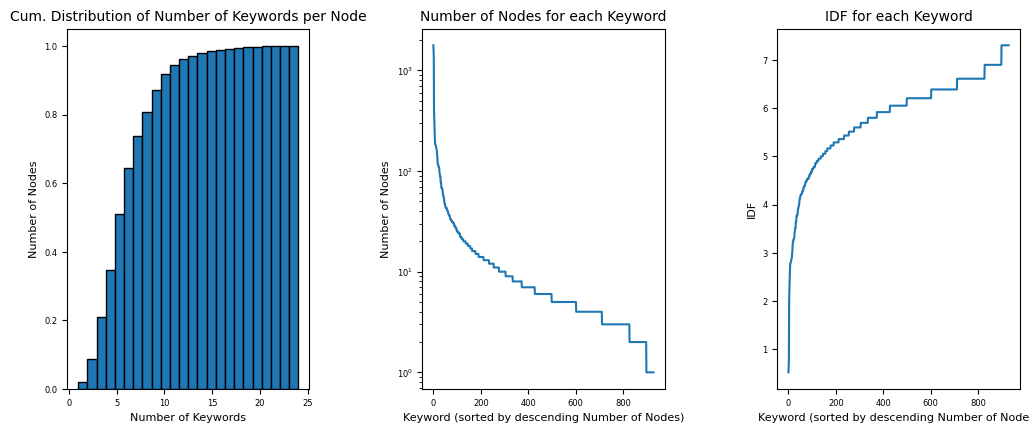

In [65]:
fig, ax = plt.subplots(1, 3, figsize = (10, 4))
fig.tight_layout(w_pad = 10)

kws_per_node.num_kws.hist(ax = ax[0], bins = max(kws_per_node.num_kws), edgecolor="black", grid = False,
                          cumulative = True, density = 1)
ax[0].set_xlabel("Number of Keywords")
ax[0].set_ylabel("Number of Nodes")
ax[0].set_title("Cum. Distribution of Number of Keywords per Node")

nodes_per_kw.sort_values(by = "num_nodes", ascending = False).num_nodes.plot(ax = ax[1], kind = "line", use_index = False)
ax[1].set_xlabel("Keyword (sorted by descending Number of Nodes)")
ax[1].set_ylabel("Number of Nodes")
ax[1].set_title("Number of Nodes for each Keyword")
ax[1].set_yscale("log")

nodes_per_kw.sort_values(by = "num_nodes", ascending = False).idf.plot(ax = ax[2], kind = "line", use_index = False)
ax[2].set_xlabel("Keyword (sorted by descending Number of Nodes)")
ax[2].set_ylabel("IDF")
ax[2].set_title("IDF for each Keyword")

#### 6.2 Decision Rules based on node embeddings

Two nodes (wikipedia pages) have an edge if they co-occur on some other random page at least once. In consequence, it might be a good idea to understand which keywords tend to occur together by finding underlying association rules (just like in the market-basket analysis).

But how do we construct the decision rules? Our goal is link prediction and there is an edge between two nodes if they occur on some other document together. To build our decision rules we only care about the actual (positive) edges in our graph. Based on the existing edges, we will then built our baskets as follows: Basket = [keywords source, keywords_target].

One important note: we have joined all key words from source and target into one big basket. This means, we might also extract decision rules for single nodes (e.g. if one node contains this keyword, it might also contain this keyword). For our task of link prediction, we will need to make sure later that we only consider decision rules that relate from one node to the other.

In [157]:
# only keep keywords with IDF greater than 5 (remove most common keywords that relate to over 1,000 nodes)
node_info_uq_idf_filtered = node_info_uq_idf[node_info_uq_idf.columns[node_info_uq_idf.max() >= 5]]

# get embedding of each node
embeddings = (node_info_map
    .reset_index()
    .merge(node_info_uq_idf_filtered, how = "left", on = "emb_id")
    .drop(columns = ["emb_id"], inplace = False)
    .set_index("node").sort_index()
)

# remove IDF of embeddings (for decision rules we need binary matrix)
embeddings[embeddings != 0] = 1

In [164]:
# get decision rules
_, rule_finder_dict, rule_values_dict = prepData.get_decision_rules(G.edges(), embeddings)
len(rule_values_dict)

50

In [165]:
# show first three decision rules
for count, (items, value_dict) in enumerate(rule_values_dict.items()):
    
    if count < 3:

        # rule
        print(f"Rule: {items[0]} -> {items[1]}")

        # properties of this rule
        print(f"Support: {value_dict['support']}")
        print(f"Confidence: {value_dict['confidence']}")
        print(f"Lift: {value_dict['lift']}")
        print("=====================================")

Rule: 5 -> 397
Support: 22.0
Confidence: 0.7333333333333333
Lift: 76.51599999999999
Rule: 285 -> 7
Support: 30.999999999999996
Confidence: 0.6458333333333333
Lift: 102.10037878787878
Rule: 506 -> 7
Support: 27.0
Confidence: 0.5625
Lift: 61.13671875


#### 6.3 Dimensionality Reduction of Node Embedding

Let us see if we can create a meaningful clustering based on the embeddings of each node. This is based on the intuition that nodes that share many keywords should likely belong to the same cluster (e.g. Wikipedia sports vs math pages).

However, the embedding of each node is of very high dimension. Let us first try to reduce the dimensionality before clustering the data. First, I thought about using PCA -- however, for this problem it is probably a very bad idea. See below cell.

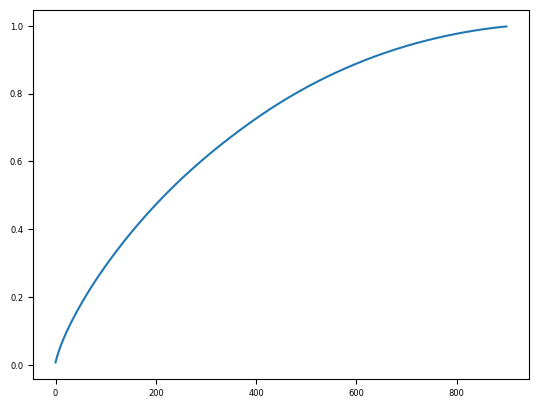

In [39]:
# create PCA embedding
n_components = []
explained_variance = []

# scale data
scaler = StandardScaler()

# perform pca
pca = PCA(n_components = 900)
pca.fit(scaler.fit_transform(node_info_idf))

# get embedding
embedding = PCA(n_components = 10).fit_transform(node_info_idf)

# look at explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_variance)

We can see that PCA has a very hard time to explain the variance in the IDF-transformed embeddings (but also same for original binary features). Why? PCA can only find linear relations based on the global structure -- but in a very sparse binary matrix we will probably have many non-linear relations.

In addition, regarding the embedding itself, PCA has another problem: local neighborhoods are not preserved (far away points can become nearest neighbors in projected subspace).

However, we want to preserve local neighborhoods, at least to some extent. In consequence, I will use an Autoencoder to reduce the dimensionality (it's a neural network so it can easily learn non-linear relations) and then run UMAP on the dense matrix to create an embedding that preserves the local neighborhood.

In [42]:
# create umap embedding of nodes
reducer = umap.UMAP(metric = "cosine",
                    n_neighbors=15,
                    min_dist=0,
                    n_components=2).fit(node_info_uq_idf)

embedding = reducer.transform(node_info_uq_idf)

Text(0.5, 1.0, 'UMAP projection (first 2 dim) of Node information')

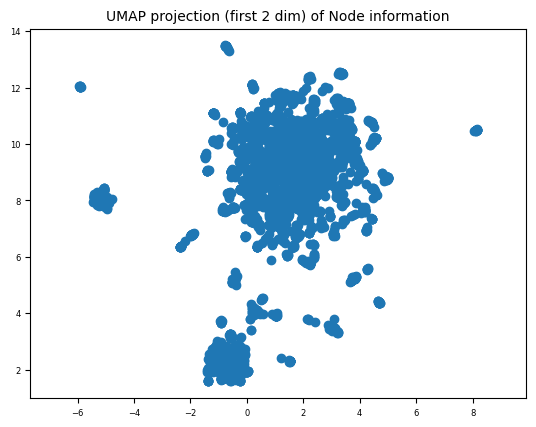

In [43]:
# plot umap embedding of nodes
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection (first 2 dim) of Node information')

In [46]:
# use umap embedding to cluster nodes
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size = 100)
clusterer.fit(embedding)

clustered = (clusterer.labels_ >= 0)
print(f"Share of clustered nodes: {np.sum(clustered) / node_info.shape[0]}")

Share of clustered nodes: 0.7781484570475397


In [47]:
# look at clusters
np.unique(clusterer.labels_, return_counts = True)

(array([-1,  0,  1,  2], dtype=int64),
 array([ 173,  125,  542, 2132], dtype=int64))

<AxesSubplot: ylabel='$\\lambda$ value'>

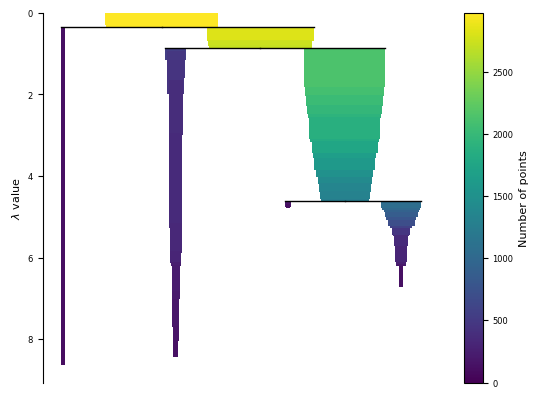

In [48]:
# visualize clusters of HDBSCAN
clusterer.condensed_tree_.plot()

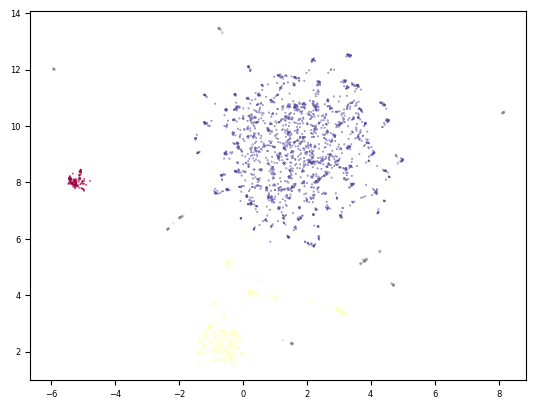

In [49]:
# plot clustered nodes based on their embedding
plt.scatter(embedding[~clustered, 0],
            embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=clusterer.labels_[clustered],
            s=0.1,
            cmap='Spectral')

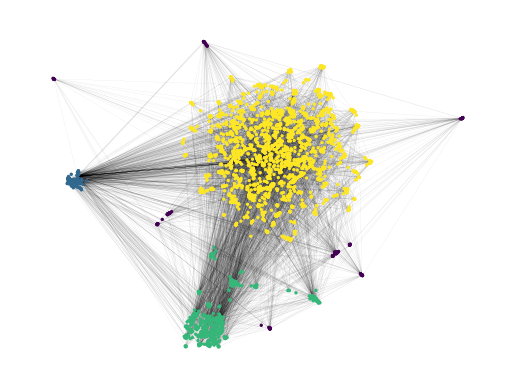

In [50]:
# use embedding and cluster of each node to visualize graph
data_emb = dict()
for i, emb in enumerate(node_info_uq.index):
    data_emb[emb] = {"emb_1": embedding[i][0], "emb_2": embedding[i][1], "cluster": clusterer.labels_[i]}

data_node = dict()
for i, node in enumerate(node_info.index):
    data_node[node] = data_emb[node_info_map.emb_id.loc[node]]

nodes = G.nodes()
pos = {node: [data_node[node]["emb_1"], data_node[node]["emb_2"]] for node in nodes}
labels = [data_node[node]["cluster"] for node in nodes]

nx.draw_networkx_edges(G, pos, alpha=0.2, width = 0.1)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=2, node_color=labels)
plt.axis('off')

plt.show()

In [51]:
# compute connectedness between groups
node_stats = (pd.DataFrame.from_dict(data_node, orient = "index")
    .assign(degree = lambda df_: [G.degree(node) for node in df_.index])
    .assign(neighbors = lambda df_: [[df_.loc[node].cluster for node in G.neighbors(node)] for node in df_.index])
    .assign(neighbors = lambda df_: [[lst.count(i) for i in np.unique(labels)] for lst in df_.neighbors])
)

node_stats = (pd.concat([node_stats, node_stats.neighbors.apply(pd.Series).divide(node_stats.degree, axis=0).round(2)], axis=1)
    .rename(columns = {idx: cluster for idx, cluster in zip(range(len(np.unique(labels))), np.unique(labels))})
)

agg_dict = {col: "mean" for col in list(np.unique(labels))}
agg_dict["degree"] = "sum"
agg_dict["cluster"] = "count"
(node_stats
    .groupby("cluster").agg(agg_dict).rename(columns = {"cluster" : "nbr_nodes"}).round(2)
    .assign(avg_degree = lambda df_: (df_.degree / df_.nbr_nodes).round(2))
)

,-1,0,1,2,degree,nbr_nodes,avg_degree
cluster,,,,,,,
-1,0.09,0.10,0.21,0.61,570,217,2.63
0,0.04,0.11,0.18,0.67,758,152,4.99
1,0.06,0.09,0.21,0.64,1933,677,2.86
2,0.05,0.11,0.18,0.67,7173,2551,2.81
